# Lab CMBLenses

## Model

In [1]:
using CMBLensing, CMBLensingInferenceTestProblem
using CUDA, LaTeXStrings, MCMCDiagnosticTools, Plots, ProgressMeter, Random, Zygote
using LinearAlgebra, Statistics
ENV["LINES"] = 10;

In [2]:
using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
prob = load_cmb_lensing_problem(storage = Array,
                                T = Float32,
                                Nside = 64);

In [4]:
target = CMBLensingTarget(prob);

In [5]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)

(CMBLensingInferenceTestProblem.var"#to_vec#2"(), CMBLensingInferenceTestProblem.var"#from_vec#3"{Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float32, Vector{Float32}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}}(Float32[-4.7993712, -10.132681, -13.010162, -9.098768, -3.4189508, -2.647602, -2.2184951, -1.8052056, -3.8572881, -6.549067  …  -1.4671382f-6, -1.5210153f-6, -1.5569877f-6, -1.597326f-6, -1.6578678f-6, -1.7366059f-6, -1.8154062f-6, -1.8714119f-6, -1.609438, 0.0]))

## Sample

In [6]:
spl=MCHMC(10.0, 10.0*sqrt(50); sigma=one(LenseBasis(diag(target.Λmass))))

MicroCanonicalHMC.Sampler(Settings(MersenneTwister(0), 0.2, 0, 20, 10, "LF", nothing, nothing, nothing), Hyperparameters(10.0, 70.71067811865476, 0.0, 0.1931833275037836, Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), MicroCanonicalHMC.Leapfrog)

In [7]:
samples = Sample(spl, target, 500; dialog=true)

[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅


501-element Vector{Any}:
 [-4.781805038452148, -10.115113258361816, -12.992595672607422, -9.081202507019043, -3.4013853073120117, -2.6300344467163086, -2.2009286880493164, -1.7876393795013428, -3.8397207260131836, -6.531499862670898  …  -1.556987626827322e-6, -1.5973259905877057e-6, -1.657867642279598e-6, -1.7366054407830234e-6, -1.815406449168222e-6, -1.8714119960350217e-6, -1.6094379425048828, 0.0, 0.0, 98678.2265625]
 [-4.757622238309145, -10.132147638774823, -13.02079803837237, -9.067848310571211, -3.3391413574371924, -2.6476873882249423, -2.1941522043740305, -1.7602690342199772, -3.733367760336089, -6.636371715854751  …  -1.5141718701001139e-6, -1.5441080961426398e-6, -1.599287818948694e-6, -1.680668278820282e-6, -1.7660333960783403e-6, -1.8283054413388293e-6, -1.5036310071725774, 0.1433769128546231, -1.3297444366035052, 98627.67348924513]
 [-4.718225816960809, -10.102692319776256, -13.045180974031593, -9.090941625651514, -3.308963127801628, -2.648758808107522, -2.174395074575593,

In [8]:
samples_redux = []
for sample in samples
    if all(isfinite.(sample))
            append!(samples_redux, [sample])
    end
end    

In [9]:
_samples = zeros(length(samples), length(samples[1]), 1)
_samples[:, :, 1] = mapreduce(permutedims, vcat, samples)
_samples = permutedims(_samples, (1,3,2))
ess, rhat = MCMCDiagnosticTools.ess_rhat(_samples)

([10.970955273032658, 15.906892242519184, 10.461444629919983, 14.201132696254582, 2.0801336876921077, 19.853519851041845, 11.389237493050121, 15.458102335710675, 11.115379821751949, 22.500305166415732  …  26.428396142947513, 19.10633287789285, 14.903379221871246, 8.80249152451388, 5.90239297386191, 5.005970857289018, 16.903399144776614, 53.930049279733545, 583.689446755113, 36.60109761651755], [1.0514985846826732, 1.0075810470829558, 0.9982360686083299, 1.0177039124780956, 1.5608997236229836, 1.0181643182953373, 1.0195124698547502, 1.0139669810305632, 1.0953605482582653, 1.0276200740849315  …  1.0507637137126615, 1.0699943270625976, 1.0821536612825793, 1.1098801811628325, 1.1439125317651417, 1.1670087097063608, 0.9982085694175515, 1.0024366532042683, 0.9980448875155962, 1.0148413401704661])

In [10]:
_ess = median(ess)

12.236511429210886

In [11]:
_rhat = median(rhat)

1.0438877943816158

## Plotting

In [12]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [13]:
rs = [sample[end-3] for sample in samples]
Aϕs = [sample[end-2] for sample in samples];

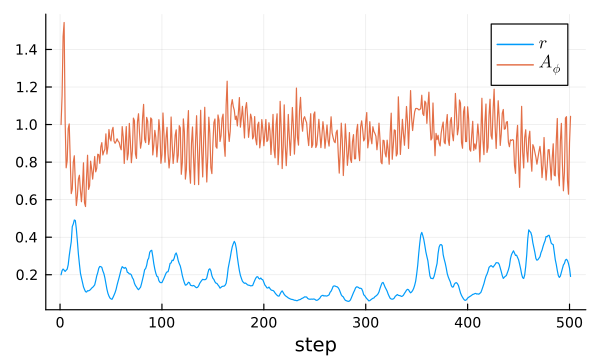

In [14]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")


In [15]:
Energy = [sample[end-1] for sample in samples];
std(Energy)^2/50

0.005749182895828501

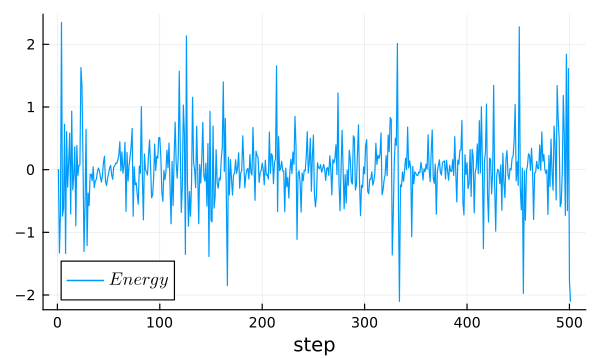

In [16]:
plot(Energy, label=L"Energy", xlabel="step")

In [ ]:
plot(histogram(exp.(rs), xlabel=L"r", label=nothing, lw=1),
    histogram(exp.(Aϕs), xlabel=L"A_\phi", label=nothing, lw=1))

In [ ]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)
last_sample = from_vec(samples[end][1:end-2])

In [ ]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(last_sample[k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)

In [ ]:
samps = [∇²*from_vec(sample[1:end-2]).ϕ°/2 for sample in samples[100:end]]
anim = @animate for i in 1:length(samps)
    motionblur = [0.5, 1, 0.5]
    frame = sum(circshift(samps, i)[1:length(motionblur)] .* motionblur) / sum(motionblur)
    plot(1 * frame, clims=(-0.5, 0.5), c=:thermal, title="κ samples")
end;

In [ ]:
mp4(anim, "kappa_samples.mp4", fps = 25)